In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from torch.utils.data import  SubsetRandomSampler


In [ ]:
import shutil

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.init()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

#### mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
!google-colab auth revoke

/bin/bash: line 1: google-colab: command not found


In [ ]:
def find_images_without_masks(image_dir, mask_dir):
    images = os.listdir(image_dir)
    masks = os.listdir(mask_dir)

    images_without_masks = [img for img in images if img not in masks]
    images_with_masks = [img for img in images if img in masks]

    return images_with_masks, images_without_masks

# Example usage
image_dir = r"/content/gdrive/MyDrive/data/Mixed/CXR_Png/"
mask_dir = r"/content/gdrive/MyDrive/data/Mixed/masks/"

images_with_masks, images_without_masks = find_images_without_masks(image_dir, mask_dir)
print("Images with corresponding masks:", len(images_with_masks))
print("Images without corresponding masks:", images_without_masks)
print("No. of Images without corresponding masks:", len(images_without_masks))



Images with corresponding masks: 801
Images without corresponding masks: []
No. of Images without corresponding masks: 0


KeyboardInterrupt: 

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out



In [ ]:


class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        filename = str(self.images[idx])
        mask_name = os.path.join(self.mask_dir, filename)

        try:
            image = Image.open(img_name).convert("L")  # Convert to grayscale
            mask = Image.open(mask_name).convert("L")  # Convert to grayscale

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            # Check for NaN values in images or masks
            if torch.isnan(image).any() or torch.isnan(mask).any():
                print(f"NaN values encountered in image or mask at index {idx}. Skipping this sample.")
                # Return empty tensors if NaN values are encountered
                image = torch.empty((1, 128, 128))
                mask = torch.empty((1, 128, 128))

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            # Return empty tensors if an error occurs
            image = torch.empty((1, 128, 128))
            mask = torch.empty((1, 128, 128))

        return {'image': image, 'mask': mask}

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create dataset
dataset = CustomDataset(image_dir, mask_dir, transform=transform)

# Get the number of samples in the dataset
num_samples = len(dataset)

# Create a random sampler with the correct number of samples
sampler = SubsetRandomSampler(range(num_samples))

# Create dataloader using the sampler
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1)
model.to(device)
# Assuming `model`, `dataloader`, and `device` are defined elsewhere




# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

best_loss = float('inf')  # Initialize best validation loss

# Gradient clipping value
clip_value = 1.0

# Training loop
for epoch in range(20):
    epoch_loss = 0.0

    # Zero the parameter gradients
    optimizer.zero_grad()

    for i, data in enumerate(dataloader):
        inputs, labels = data['image'].to(device), data['mask'].to(device)

        # Check for NaN values in inputs or labels
        if torch.isnan(inputs).any() or torch.isnan(labels).any():
            print(f"NaN values encountered in inputs or labels at index {i}. Skipping this iteration.")
            continue

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Check for NaN loss
        if torch.isnan(loss):
            print("NaN loss encountered. Skipping this iteration.")
            continue

        # Backward pass and optimize
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        epoch_loss += loss.item()

        # Add Average loss epocj_loss to wandb log
        wandb.log({"Epoch": epoch+1, "Batch": i+1, "Loss": loss.item()})
        # Print loss for every 10 batches
        if i % 10 == 0:

            print(f"Epoch [{epoch+1}/{50}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")



    # Change loss.item to epoch_loss
    if loss.item() <= 0.07:
        break

    # Calculate average epoch loss
    epoch_loss /= len(dataloader)

    print(f"Epoch [{epoch+1}/{50}], Average Loss: {epoch_loss}")






Epoch [1/50], Batch [1/51], Loss: 0.6741575002670288
Epoch [1/50], Batch [11/51], Loss: 0.6095923781394958
Epoch [1/50], Batch [21/51], Loss: 0.6155102252960205
Epoch [1/50], Batch [31/51], Loss: 0.5705959796905518
Epoch [1/50], Batch [41/51], Loss: 0.5287176370620728
Epoch [1/50], Batch [51/51], Loss: 0.4118991494178772
Epoch [1/50], Average Loss: 0.572053945532032
Epoch [2/50], Batch [1/51], Loss: 0.4814189672470093
Epoch [2/50], Batch [11/51], Loss: 0.4310189187526703
Epoch [2/50], Batch [21/51], Loss: 0.39988619089126587
Epoch [2/50], Batch [31/51], Loss: 0.40089184045791626
Epoch [2/50], Batch [41/51], Loss: 0.3771079182624817
Epoch [2/50], Batch [51/51], Loss: 0.36863768100738525
Epoch [2/50], Average Loss: 0.42332525755844863
Epoch [3/50], Batch [1/51], Loss: 0.44414931535720825
Epoch [3/50], Batch [11/51], Loss: 0.36765581369400024
Epoch [3/50], Batch [21/51], Loss: 0.3466642200946808
Epoch [3/50], Batch [31/51], Loss: 0.35406702756881714
Epoch [3/50], Batch [41/51], Loss: 0.35

KeyboardInterrupt: 

In [ ]:
# Save model checkpoint
torch.save(model.state_dict(), "/content/gdrive/MyDrive/data/AC_Mixed_Final_0.1.pth")
print("Finished Training")

Finished Training


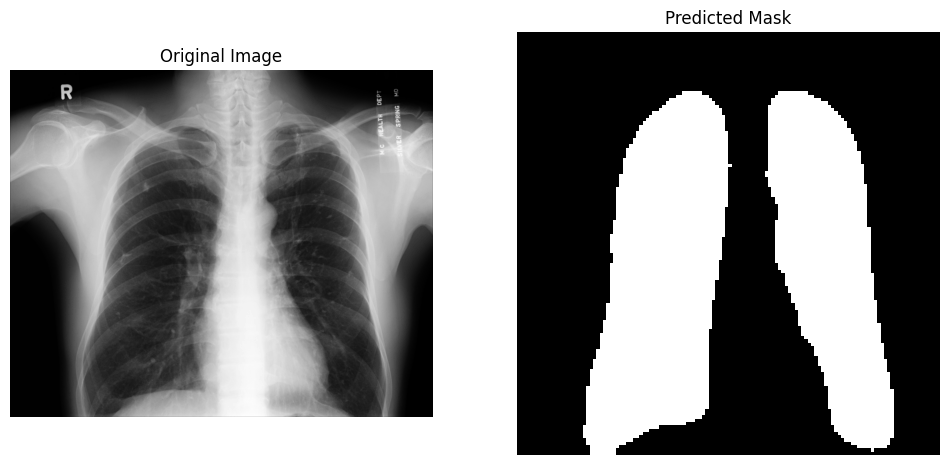

In [ ]:

# Load the saved model checkpoint
checkpoint_path = r"/content/gdrive/MyDrive/data/AC_Mixed_Final_0.1.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=1).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()  # Set model to evaluation mode

# Load the new chest X-ray image
new_image_path = r'/content/gdrive/My Drive/data/Mixed/CXR_Png/MCUCXR_0354_1.png'
new_image = Image.open(new_image_path).convert("L")  # Convert to grayscale
new_image_tensor = transform(new_image).unsqueeze(0).to(device)  # Preprocess and move to device

# Perform inference
with torch.no_grad():
    output = model(new_image_tensor)

# Convert output to probabilities using sigmoid activation
sigmoid = nn.Sigmoid()
output_probabilities = sigmoid(output)

# Convert output probabilities to binary mask
threshold = 0.5
predicted_mask = (output_probabilities > threshold).float()

# Display original image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(new_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')
plt.show()

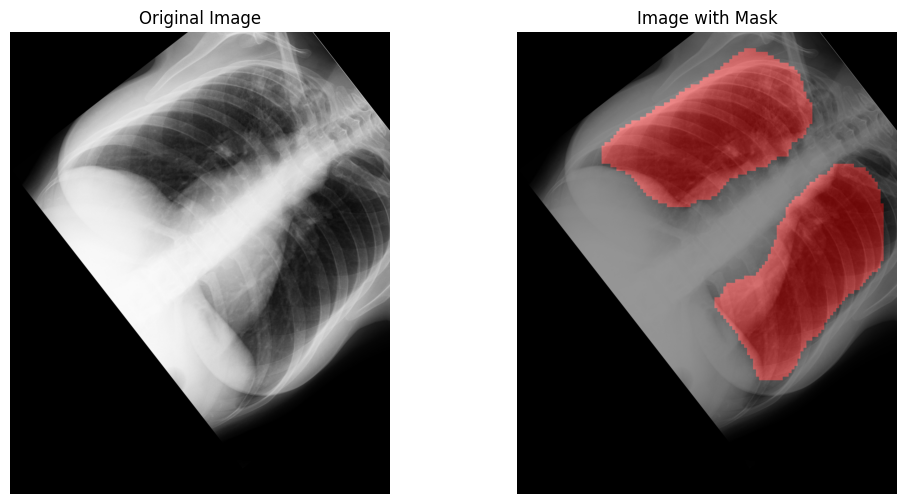

In [ ]:
import cv2


# Perform inference
with torch.no_grad():
    output = model(new_image_tensor)

# Convert output to probabilities using sigmoid activation
sigmoid = nn.Sigmoid()
output_probabilities = sigmoid(output)

# Convert output probabilities to binary mask
threshold = 0.5
predicted_mask = (output_probabilities > threshold).float()

# Convert PIL image to numpy array
new_image_np = np.array(new_image)

# Resize predicted mask to original image size
predicted_mask_np = cv2.resize(predicted_mask.squeeze().cpu().numpy(), (new_image_np.shape[1], new_image_np.shape[0]))

# Create an empty RGB image
mask_rgb = np.zeros((new_image_np.shape[0], new_image_np.shape[1], 3), dtype=np.uint8)

# Apply mask to the RGB image
mask_rgb[predicted_mask_np > 0] = [255, 0, 0]  # Red for mask

# Convert grayscale image to RGB
new_image_rgb = cv2.cvtColor(new_image_np, cv2.COLOR_GRAY2RGB)

# Superimpose the mask on the image
superimposed_img = cv2.addWeighted(new_image_rgb, 0.6, mask_rgb, 0.4, 0)

# Display original image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(new_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(superimposed_img)
axes[1].set_title('Image with Mask')
axes[1].axis('off')
plt.show()


In [ ]:
# Define the destination directory
dest_img_dir = r"/content/gdrive/MyDrive/data/Mixed/CXR_Png/"
dest_mask_dir = r"/content/gdrive/MyDrive/data/Mixed/masks/"

# Create the destination directory if it does not exist
'''
if not os.path.exists(dest_img_dir):
    os.makedirs(dest_img_dir) '''
if not os.path.exists(dest_mask_dir):
    os.makedirs(dest_mask_dir)

i=int(0)

# Loop through the images with masks and copy them to the destination directory
for img in images_with_masks:
  if i>20:
    break
  else:
    i+=1
    src_file = os.path.join(image_dir, os.path.basename(img))
    src_mask = os.path.join(mask_dir, os.path.basename(img))
    # Get the source file path
    # Get the destination file path
    dest_img_file = os.path.join(dest_img_dir, os.path.basename(img).replace(".","_aug."))
    dest_mask_file = os.path.join(dest_mask_dir, os.path.basename(img).replace(".","_aug."))
    # Copy the file
    shutil.copy(src_file, dest_img_file)
    shutil.copy(src_mask, dest_mask_file)